In [10]:
pwd

'/Users/amischel/Desktop/BAHAMAS-mock-weak-lensing'

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
import Lensing as l
import Simulation_bh as s
from astropy.cosmology import Planck18
from astropy.cosmology import WMAP9

Take zsource out of the def __init__ function, since a cluster should not be defined by the source redshift since there will be many different sources of different redshifts. Instead, include zsource as an argument for the function that calculates the shear at any given point. Also write a function to make plots of the convergence and shear (could either plot convergence0 and shear0 with default redshifts, or just have zsource and zlens as arguments with defaults of the default redshifts). 

To do:
- make separate functions that plot convergence and shear at a given extent for the image, which otherwise defaults to the SuperBIT size (stored in def __init__), and can also take a size for the BAHAMAS plot, but also otherwise defaults to something like 3 times hfov (as long as you can see th eedge of the simualtion for padding).
- these should be two separate functions that have an argument called ax that defaults to none and has an if statement that says if ax=None, then make ax=plt. that way, it can plot a single map if needed. Also use **kwargs to have all the imshow arguments encapuslated in one dictionary
- then there should be another function, which takes in inputs of convergence plot and shear plot and each respective kwargs and makes both of them side by side with all the nice pretty formatting
- remove zsource from def __init__ and basically only use it for calculating the shear at a particular point. Shouldn't even need it for plotting the convergence and shear really, because I can probably just plot convergence0 and shear0
- figure out the hfov stuff so it actually works and is consistent with everything

In [12]:
a = 10*u.Mpc
a.to_value('Mpc')
  # hdf5 files h5py to read them
    # npz files good for appearing like dictionaries

10.0

In [20]:
class BHM_cluster:
    def __init__(self, name, horizontal_axis, vertical_axis, zlens, bhm_hfov=10*u.Mpc, cosmo=Planck18):
        
        self.name = name
        self.cosmo = cosmo
        
        self.horizontal_axis = horizontal_axis
        self.vertical_axis = vertical_axis
        
        # Default redshifts for the lens and source
        self.zlens0 = 0.5
        self.zsource0 = 1.0
        
        # Actual redshift of the lens
        self.zlens = zlens
        
        # Convergence and shear assuming default lens and source redshifts - initialize as None initially
        self.convergence0 = None
        self.shear0 = None
        self.shear1_0 = None
        self.shear2_0 = None
        
        # The half of the field-of-view of the BAHAMAS simulation (in distance units, not angular distance)
        self.bhm_hfov = bhm_hfov
        
        # # The half of the field-of-view of the convergence or shear plots for the horizontal and vertical axes
        # self.hfov_hor = hfov_hor
        # self.hfov_ver = hfov_ver
        
        # The default half of the field-of-view, in this case the size of the SuperBIT field-of-view.
        self.SuperBIT_hfov_hor = 15*u.arcmin
        self.SuperBIT_hfov_ver = 10*u.arcmin
        

    def calculate_Sigma_crit(self, zsource1, zlens1):
        dL1 = self.cosmo.angular_diameter_distance(zsource1) # distance from the viewer to the lens plane
        dS1 = self.cosmo.angular_diameter_distance(zlens1) # distance from the viewer to the source plane
        dLS1 = self.cosmo.angular_diameter_distance_z1z2(zlens1, zsource1) # distance from the lens plane to the source
        Sigma_crit1 = l.Sigma_crit(dS1, dLS1, dL1)
        
        return Sigma_crit1

    def calculate_convergence0_map(self):
        
        # calculating Sigma
        Sigma = s.Sigma(self.name, self.horizontal_axis, self.vertical_axis, self.bhm_hfov)
        
        # default redshift
        Sigma_crit0 = self.calculate_Sigma_crit(self.zsource0, self.zlens0)
        
        # default convergence, so it does not need to be re-calculated
        convergence0 = l.convergence(Sigma, Sigma_crit0)
        self.convergence0 = convergence0 # save this value

        return convergence0
    
    def get_convergence0_map(self):
        if self.convergence0 is None:
            self.calculate_convergence0_map()
            return self.convergence0
        else:
            return self.convergence0
    
    def calculate_shear0_map(self):
        self.shear1_0, self.shear2_0, self.shear0 = l.shear(self.calculate_convergence0_map())
        return self.shear1_0, self.shear2_0, self.shear0
    
    def get_shear0_map(self):
        if self.shear0 is None:
            self.calculate_shear0_map()
            return self.shear1_0, self.shear2_0, self.shear0
        else:
            return self.shear1_0, self.shear2_0, self.shear0

        
    def evaluate_shear(self, zlens):
        # actual redshift
        Sigma_crit = self.calculate_Sigma_crit(self.zsource, zlens)
        
        # adjust actual value of convergence to account for non-default redshifts
        redshift_adjustment = Sigma_crit0/Sigma_crit
        
        convergence = convergence0 * redshift_adjustment
        
        # just including these in here because they will be useful later
        
    def calculate_extent(self):
        extent_new = ((self.hfov/self.cosmo.angular_diameter_distance(self.zlens))*u.rad).to_value('arcmin')
        
    
    def plot_convergence0(self, ax=None, hfov_hor=None, hfov_ver=None, **kwargs):
        if hfov_hor is None:
            hfov_hor = self.SuperBIT_hfov_hor
            
        if hfov_ver is None:
            hfov_ver = self.SuperBIT_hfov_ver
            
        # if convergence_kwargs is None:
        #     convergence_kwargs = {}
            
        if ax is None:
            fig, ax = plt.subplots()
            ax.set_xlabel(self.horizontal_axis + '-coord (arcmin)')
            ax.set_ylabel(self.vertical_axis + '-coord (arcmin)')
            ax.set_title('Convergence0')
            
        # Since BAHAMAS simulations are performed independent of the distance to the clusters, the scales are in Mpc
        # To convert to an extent which is dependent on the distance to the lens (as used by SuperBIT), the scale will instead be in arcmin
        extent_img = (((self.bhm_hfov/(self.cosmo.angular_diameter_distance(self.zlens))).to_value(''))*u.rad).to_value('arcmin')

        convergence_plt = ax.imshow((np.log10(self.get_convergence0_map()+1e-5)).T, origin = 'lower', extent = [-extent_img, extent_img, -extent_img, extent_img], **kwargs)
        
        ax.set_xlim(-hfov_hor.to_value('arcmin'), hfov_hor.to_value('arcmin'))
        ax.set_ylim(-hfov_ver.to_value('arcmin'), hfov_ver.to_value('arcmin'))
        # plt.colorbar(convergence_plt, fraction=0.046, pad=0.04)
        
        #plt.show()
        
        
    def plot_shear0(self, ax=None, hfov_hor=None, hfov_ver=None, **kwargs):
        if hfov_hor is None:
            hfov_hor = self.SuperBIT_hfov_hor
            
        if hfov_ver is None:
            hfov_ver = self.SuperBIT_hfov_ver
            
        # if convergence_kwargs is None:
        #     convergence_kwargs = {}
            
        if ax is None:
            fig, ax = plt.subplots()
            ax.set_xlabel(self.horizontal_axis + '-coord (arcmin)')
            ax.set_ylabel(self.vertical_axis + '-coord (arcmin)')
            ax.set_title('Shear0')
            
        # Since BAHAMAS simulations are performed independent of the distance to the clusters, the scales are in Mpc
        # To convert to an extent which is dependent on the distance to the lens (as used by SuperBIT), the scale will instead be in arcmin
        extent_img = (((self.bhm_hfov/(self.cosmo.angular_diameter_distance(self.zlens))).to_value(''))*u.rad).to_value('arcmin')

        shear_plt = ax.imshow((np.log10((self.get_shear0_map())[2]+1e-5)).T, origin = 'lower', extent = [-extent_img, extent_img, -extent_img, extent_img], **kwargs)
        
        ax.set_xlim(-hfov_hor.to_value('arcmin'), hfov_hor.to_value('arcmin'))
        ax.set_ylim(-hfov_ver.to_value('arcmin'), hfov_ver.to_value('arcmin'))
        #plt.colorbar(shear_plt, fraction=0.046, pad=0.04)
        
        #plt.show()
    
    def plot_convergence0_and_shear0(self, hfov_hor, hfov_ver, convergence0_kwargs = {}, shear0_kwargs = {}):
        
        # convergence0_kwargs = kwargs.get('convergence_kwargs', {})
        # shear0_kwargs = kwargs.get('shear_kwargs', {})
        
        fig, (ax1, ax2) = plt.subplots(1,2)
        
        self.plot_convergence0(ax=ax1, hfov_hor=hfov_hor, hfov_ver = hfov_ver, **convergence0_kwargs)
        self.plot_shear0(ax=ax2, hfov_hor=hfov_hor, hfov_ver = hfov_ver, **shear0_kwargs)

        ax1.set_title('Convergence ($\kappa$)')
        ax2.set_title('Shear ($\gamma$)')
        ax1.set_xlabel(self.horizontal_axis + '-coord (arcmin)')
        ax2.set_xlabel(self.horizontal_axis + '-coord (arcmin)')
        
        ax1.set_ylabel(self.vertical_axis + '-coord (arcmin)')
        ax2.tick_params(left=False)
        ax2.set(yticklabels=[])
            
        plt.tight_layout()

In [21]:
baham2 = BHM_cluster(name = 'GrNm_001.npz', horizontal_axis = 'x', vertical_axis = 'y', zlens = 0.1)

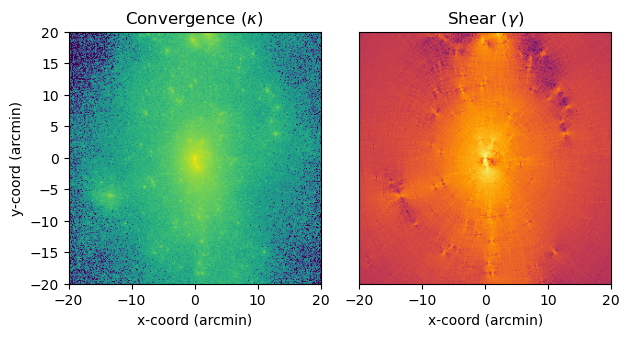

In [22]:
baham2.plot_convergence0_and_shear0(hfov_hor = 20*u.arcmin, hfov_ver = 20*u.arcmin, convergence0_kwargs={}, shear0_kwargs={'vmin' : -3, 'cmap' : 'inferno'})

In [16]:
baham3 = BHM_cluster(name = 'GrNm_001.npz', horizontal_axis = 'x', vertical_axis = 'y', zlens = 0.9)

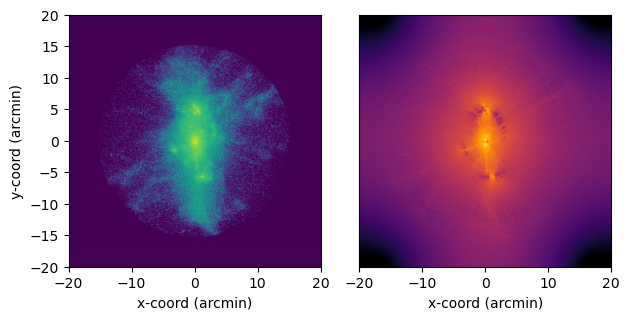

In [17]:
baham3.plot_convergence0_and_shear0(hfov_hor = 20*u.arcmin, hfov_ver = 20*u.arcmin, convergence0_kwargs={}, shear0_kwargs={'vmin' : -3, 'cmap' : 'inferno'})

use blurring before solving the "whichpoint do you choose for a shear evaluation point" question using pysphviewer

In [18]:
plt.imshow((np.log10(baham2.calculate_convergence0_map() + 1e-5)).T, origin='lower', extent = [-extent_new, extent_new, -extent_new, extent_new])
plt.colorbar()
plt.xlabel('x (arcmin)')
plt.ylabel('y (arcmin)')
# plt.xlim(-15,15)
# plt.ylim(-15,15)

NameError: name 'extent_new' is not defined

In [19]:
baham2yz = BHM_cluster(name = 'GrNm_001.npz', horizontal_axis = 'y', vertical_axis = 'z', extent = 'test', zlens = 0.5, hfov = 5*0.700*3)
plt.imshow((np.log10(baham2yz.get_convergence0_map() + 1e-5)).T, origin='lower')

TypeError: BHM_cluster.__init__() got an unexpected keyword argument 'extent'